In [1]:
import sys, os, datetime
sys.path.append("../../")

from utils.contract_utils import init_contract
from utils.network_utils import configure_network_and_connect

import brownie

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [3]:
ALCHEMY_API_KEY = os.environ['ALCHEMY_API_KEY']
configure_network_and_connect(
    node_provider_https=f"https://eth-mainnet.alchemyapi.io/v2/{ALCHEMY_API_KEY}",
    network_name='mainnet'
)

# Settings

In [4]:
crv_depositor_contract_genesis_block = 12451019
crv_depositor_contract_genesis_block_time = datetime.datetime.fromtimestamp(
    brownie.web3.eth.getBlock(
        crv_depositor_contract_genesis_block
    ).timestamp
)
convex_voterproxy_addr = "0x989AEb4d175e16225E39E87d0D97A3360524AD80"

In [5]:
vecrv_contract = init_contract("0x5f3b5DfEb7B28CDbD7FAba78963EE202a494e2A2")

# calculate historic and current balances

In [6]:
block_steps = 10000
current_block = brownie.web3.eth.block_number
next_block = crv_depositor_contract_genesis_block - 200 * block_steps
data = {"block": [], "timestamp": [], "vecrv_supply": [], 'voterproxy_balance': []}
while next_block < current_block:

    try:

        vecrv_total_supply = vecrv_contract.totalSupplyAt(next_block)
        voterproxy_vecrv_balance = vecrv_contract.balanceOfAt(convex_voterproxy_addr, next_block)

        block_time = datetime.datetime.fromtimestamp(brownie.web3.eth.getBlock(next_block).timestamp)

        data['block'].append(next_block)
        data['timestamp'].append(block_time)
        data['vecrv_supply'].append(vecrv_total_supply)
        data['voterproxy_balance'].append(voterproxy_vecrv_balance)

        next_block = min(next_block + block_steps, current_block)

    except:

        next_block = min(next_block + block_steps, current_block)
        continue


In [7]:
data = pd.DataFrame(data)
data.set_index('timestamp', inplace=True)
data.vecrv_supply = data.vecrv_supply * 1e-18
data.voterproxy_balance = data.voterproxy_balance * 1e-18

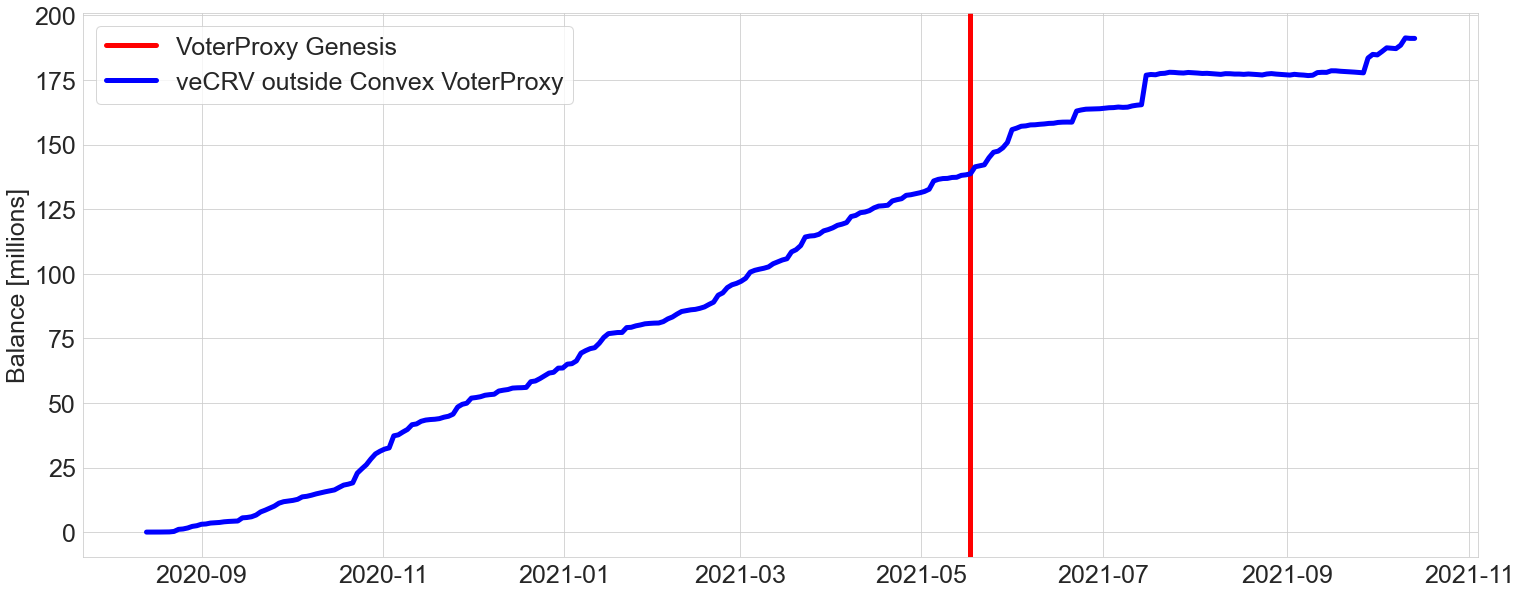

In [8]:
fig, ax = plt.subplots(1,1, figsize=(25, 10))

ax.axvline(
    x=crv_depositor_contract_genesis_block_time,
    label='VoterProxy Genesis',
    color='r',
    lw=5
)
ax.plot(
    data.index,
    (data.vecrv_supply - data.voterproxy_balance) * 1e-6,
    marker='',
    color='b',
    lw=5,
    ms=10,
    label='veCRV outside Convex VoterProxy'
)
ax.tick_params(axis='both', which='major', labelsize=25);
ax.legend(fontsize=25)
ax.set_ylabel("Block Number", fontsize=25)
ax.set_ylabel("Balance [millions]", fontsize=25);

In [9]:
import numpy as np

In [10]:
future_blocks = np.linspace(data.block[0], data.block[-1], 1000)
future_blocks

array([10651019.        , 10653781.76276276, 10656544.52552553,
       10659307.28828829, 10662070.05105105, 10664832.81381381,
       10667595.57657658, 10670358.33933934, 10673121.1021021 ,
       10675883.86486487, 10678646.62762763, 10681409.39039039,
       10684172.15315315, 10686934.91591592, 10689697.67867868,
       10692460.44144144, 10695223.2042042 , 10697985.96696697,
       10700748.72972973, 10703511.49249249, 10706274.25525526,
       10709037.01801802, 10711799.78078078, 10714562.54354354,
       10717325.30630631, 10720088.06906907, 10722850.83183183,
       10725613.59459459, 10728376.35735736, 10731139.12012012,
       10733901.88288288, 10736664.64564565, 10739427.40840841,
       10742190.17117117, 10744952.93393393, 10747715.6966967 ,
       10750478.45945946, 10753241.22222222, 10756003.98498498,
       10758766.74774775, 10761529.51051051, 10764292.27327327,
       10767055.03603604, 10769817.7987988 , 10772580.56156156,
       10775343.32432432, 10778106.08708

In [15]:
pre_voterproxy = data[data.block < crv_depositor_contract_genesis_block]
m, b = np.polyfit(pre_voterproxy.block.values.astype('float'), pre_voterproxy.vecrv_supply.values.astype('float'), 1)
vecrv_growth_without_voterproxy = m * data.block.values + b

In [16]:
post_voterproxy = data[data.block > crv_depositor_contract_genesis_block]
m, b = np.polyfit(post_voterproxy.block.values.astype('float'), post_voterproxy.vecrv_supply.values.astype('float'), 1)
vecrv_growth_after_voterproxy = m * data.block.values + b

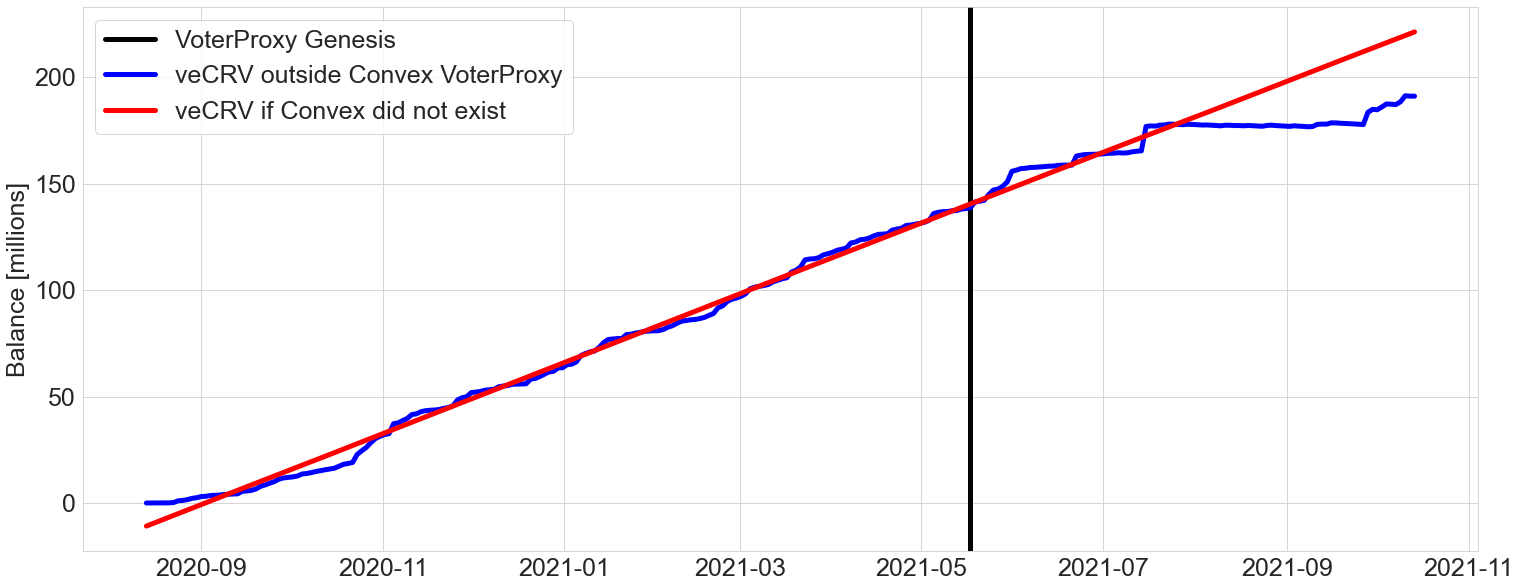

In [17]:
fig, ax = plt.subplots(1,1, figsize=(25, 10))

ax.axvline(
    x=crv_depositor_contract_genesis_block_time,
    label='VoterProxy Genesis',
    color='k',
    lw=5
)
ax.plot(
    data.index,
    (data.vecrv_supply - data.voterproxy_balance) * 1e-6,
    marker='',
    color='b',
    lw=5,
    ms=10,
    label='veCRV outside Convex VoterProxy'
)

ax.plot(
    data.index,
    vecrv_growth_without_voterproxy * 1e-6,
    marker='',
    color='r',
    lw=5,
    ms=10,
    label='veCRV if Convex did not exist'
)

ax.tick_params(axis='both', which='major', labelsize=25);
ax.legend(fontsize=25)
ax.set_ylabel("Block Number", fontsize=25)
ax.set_ylabel("Balance [millions]", fontsize=25);